# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [138]:
# Import necessary libraries
import pandas as pd

import holidays
import statsmodels.api as sm
import warnings
import itertools
from sklearn.model_selection import train_test_split

from Data.load_data import get_energy_data
from helper_functions import create_error_metrics

## Model Selection

[Discuss the type(s) of models you consider for this task, and justify the selection.]



## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


In [162]:
german_holidays = holidays.country_holidays("Germany", years=[2017, 2018, 2019], subdiv="BY") + holidays.country_holidays("Germany", years=[2017, 2018, 2019], subdiv="SH")

In [163]:
def create_dummy_variables(prefix: str, df_total_temp: pd.DataFrame, df_temp: pd.DataFrame) -> pd.DataFrame:
    df_dummies = pd.get_dummies(df_temp, prefix=prefix, drop_first=True)
    df_dummies.index = df_total_temp.index
    return df_dummies

In [172]:
df = get_energy_data()
df = pd.concat([
    df,
    create_dummy_variables("hour", df, df.index.hour),
    create_dummy_variables("dayofweek", df, df.index.dayofweek),
    create_dummy_variables("month", df, df.index.month),
    # create_dummy_variables("dayofyear", df, df.index.dayofyear),
    create_dummy_variables("isweekend", df, df.index.weekday),
    create_dummy_variables("isHoliday", df, pd.DataFrame(["non-holiday" if x not in german_holidays else german_holidays.get(x) for x in df.index.date])),
], axis=1)
df

,Load,Temperature,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,isHoliday_Easter Monday,isHoliday_Epiphany,isHoliday_German Unity Day,isHoliday_Good Friday,isHoliday_Labor Day,isHoliday_New Year's Day,isHoliday_Reformation Day,isHoliday_Second Day of Christmas,isHoliday_Whit Monday,isHoliday_non-holiday
Date (UTC),,,,,,,,,,,,,,,,,,,,,
2016-12-31 23:00:00+00:00,188528.8,-2.2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2017-01-01 00:00:00+00:00,183256.4,-2.4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2017-01-01 01:00:00+00:00,177785.3,-2.5,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2017-01-01 02:00:00+00:00,172906.9,-2.7,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2017-01-01 03:00:00+00:00,169715.8,-2.8,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 18:00:00+00:00,208132.8,1.8,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2019-12-31 19:00:00+00:00,195995.3,1.4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2019-12-31 20:00:00+00:00,188942.4,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [173]:
X = df.loc[:, (df.columns != 'Temperature') & (df.columns != 'Load')]
y = df['Load']

# # Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [139]:
def run_grid_search(p_max: int, q_max: int, d_max: int):
    q = range(0, q_max)
    d = range(0, d_max)
    p = range(0, p_max)
    
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    
    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    i = 0
    AIC = []
    SARIMAX_model = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                i+=1
                print('The iteration',i)
                print('length of pdq',len(pdq))
                print('length of seasonalpdq',len(seasonal_pdq))
                mod = sm.tsa.statespace.SARIMAX(endog=y_train,
                                                exog=X_train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
    
                results = mod.fit()
    
                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
                AIC.append(results.aic)
                SARIMAX_model.append([param, param_seasonal])
            except:
                continue
    
    print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

# run_grid_search(2, 2, 2)

The iteration 1
length of pdq 8
length of seasonalpdq 8
The iteration 2)x(0, 0, 0, 24) - AIC:655316.7290392782
length of pdq 8
length of seasonalpdq 8
The iteration 3)x(0, 0, 1, 24) - AIC:464734.25966720737
length of pdq 8
length of seasonalpdq 8
The iteration 4
length of pdq 8
length of seasonalpdq 8
The iteration 5
length of pdq 8
length of seasonalpdq 8
The iteration 6)x(1, 0, 0, 24) - AIC:464353.143082983
length of pdq 8
length of seasonalpdq 8
The iteration 7)x(1, 0, 1, 24) - AIC:464306.79289422324
length of pdq 8
length of seasonalpdq 8
The iteration 8
length of pdq 8
length of seasonalpdq 8
The iteration 9
length of pdq 8
length of seasonalpdq 8
The iteration 10x(0, 0, 0, 24) - AIC:459412.6315696341
length of pdq 8
length of seasonalpdq 8
The iteration 11x(0, 0, 1, 24) - AIC:455348.37477565807
length of pdq 8
length of seasonalpdq 8
The iteration 12
length of pdq 8
length of seasonalpdq 8
The iteration 13
length of pdq 8
length of seasonalpdq 8
The iteration 14x(1, 0, 0, 24) - A

## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [174]:
mod = sm.tsa.statespace.SARIMAX(
    y_train, X_train, 
    # order=(1,1,1), seasonal_order=(1, 0, 1, 24))
order=(1,0,1), seasonal_order=(0, 0, 0, 24))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   Load   No. Observations:                21024
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -217668.059
Date:                Sun, 28 Jan 2024   AIC                         435462.118
Time:                        23:12:59   BIC                         435963.183
Sample:                    12-31-2016   HQIC                        435625.655
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
hour_1                             7108.9522    245.138     29.000      0.000    6628.491    7589.414
hour_2                             9527.1869    651.069     14

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [175]:
df_result = res.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)

In [176]:
df_result

2019-05-26 23:00:00+00:00    161812.444844
2019-05-27 00:00:00+00:00    191466.251220
2019-05-27 01:00:00+00:00    195848.060229
2019-05-27 02:00:00+00:00    195974.449675
2019-05-27 03:00:00+00:00    201470.284941
                                 ...      
2019-12-31 18:00:00+00:00    277297.762993
2019-12-31 19:00:00+00:00    266033.762993
2019-12-31 20:00:00+00:00    254625.762993
2019-12-31 21:00:00+00:00    242145.762993
2019-12-31 22:00:00+00:00    228545.762993
Freq: H, Name: predicted_mean, Length: 5256, dtype: float64

<Axes: xlabel='Date (UTC)'>

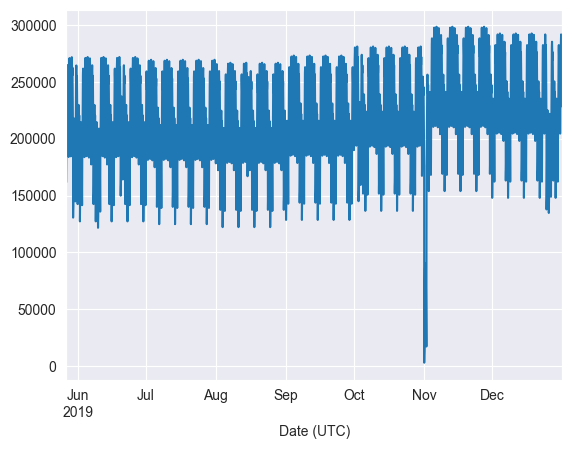

In [177]:
df_result.index = X_test.index
df_result.plot()

<Axes: xlabel='Date (UTC)'>

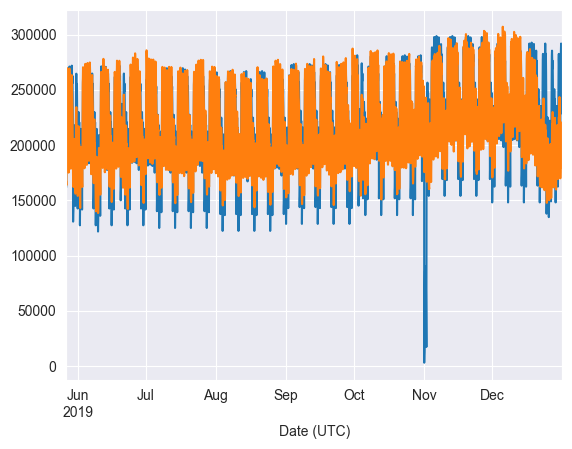

In [181]:
df_result.plot()
y_test.plot()

<Axes: xlabel='Date (UTC)'>

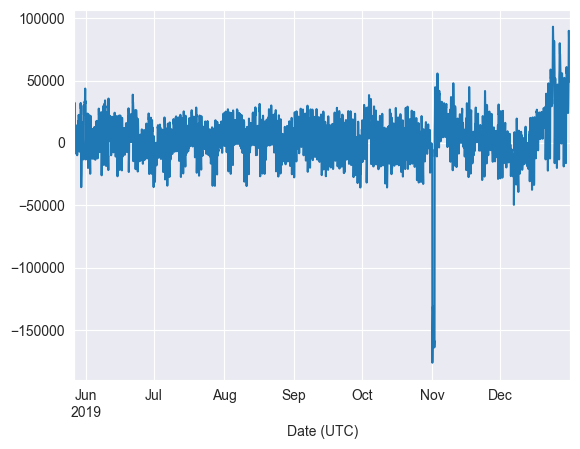

In [178]:
df_residuals = df_result - y_test
df_residuals.plot()

In [179]:
create_error_metrics(y_test, df_result)

,MAE,MSE,RMSE,MAPE %,R2 %
0,12926.55,3.780120e+08,19442.53,6.3,75.03


In [146]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

# Example for regression
# mse = mean_squared_error(y_test, y_pred)

# Your evaluation code here


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [137]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
